In [1]:
import yfinance as yf

In [2]:
missing_data_tickers = []

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
# create time periods for where this takes place
economic_cycle_periods = {
    'all_data':('2000-01-01','2024-08-01'),
    "trough": ("2008-01-01", "2009-07-01"),
    "contraction": ("2020-02-01", "2020-04-01"),
    "expansion": ("2016-01-01", "2020-01-01"),
    "recovery": ("2020-10-01", "2024-09-02")
}

economic_cycle_periods_list = ['all_data','trough','contraction','expansion','recovery']

In [5]:
# create etf tickers
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'XLC', # communication services
    'XLU', # utilities
    'XLRE' # real estate
    ]

In [6]:
# save data for sector etfs from 2000 to 2024-08-01
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

An error occurred for ticker XLC: Stock data for ticker XLC during the period from 2008-01-01 to 2009-07-01 was not found.


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['XLRE']: YFChartError("%ticker%: Data doesn't exist for startDate = 1199163600, endDate = 1246420800")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


An error occurred for ticker XLRE: Stock data for ticker XLRE during the period from 2008-01-01 to 2009-07-01 was not found.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [7]:
import numpy as np
# create bollinger bands
import scipy.stats as stats
def add_bollinger_data(data,window,conf_int):
        z_score = stats.norm.ppf(1 - (1 - conf_int) / 2) # create a zscore from the mean

        data['middle_band'] = data['Adj Close'].rolling(window).mean()
        data['upper_band'] = data['middle_band'] + z_score * data['Adj Close'].rolling(window).std()
        data['lower_band'] = data['middle_band'] - z_score * data['Adj Close'].rolling(window).std()

        data['Signal'] = None

        data['Signal'] = np.where(data['Adj Close'] < data['lower_band'], 'Buy', 
                              np.where(data['Adj Close'] > data['upper_band'], 'Sell', np.nan))

        return data

In [8]:
# create bollinger data for multiple time period and multiple tickers
def bollinger_data_multiple_periods_tickers(periods,tickers,data,window,confidence_period):
    # for each ticker in economic time periods
    for period in periods:
            for ticker in tickers:
                    try:
                        add_bollinger_data(data[period][ticker],window,confidence_period)
                    except KeyError:
                        print(f'Data for {ticker} does not exist during {period}')

In [45]:
for ticker in sector_etf_tickers:
    bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,20,0.99)

Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough
Data for XLC does not exist during trough
Data for XLRE does not exist during trough


In [46]:
import matplotlib.pyplot as plt
data = sector_etf_data['all_data']['XLB']
data

,Open,High,Low,Close,Adj Close,Volume,middle_band,upper_band,lower_band,Signal
Date,,,,,,,,,,
2000-01-03,26.671875,26.687500,25.937500,25.968750,14.953669,140500,NaN,NaN,NaN,nan
2000-01-04,26.000000,26.046875,25.609375,25.718750,14.809717,258000,NaN,NaN,NaN,nan
2000-01-05,26.015625,26.812500,25.750000,26.781250,15.421535,102700,NaN,NaN,NaN,nan
2000-01-06,26.796875,27.734375,26.781250,27.468750,15.817421,1335000,NaN,NaN,NaN,nan
2000-01-07,27.750000,27.937500,27.453125,27.453125,15.808434,620100,NaN,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...
2024-07-25,89.199997,90.949997,89.120003,89.860001,89.860001,5026000,89.3080,93.322350,85.293649,nan
2024-07-26,90.449997,91.680000,90.239998,91.330002,91.330002,3534900,89.4575,93.587805,85.327195,nan
2024-07-29,91.389999,91.739998,90.989998,91.489998,91.489998,3524800,89.6165,93.843274,85.389726,nan


In [47]:
data['Signal'].value_counts()

nan     6066
Buy       82
Sell      35
Name: Signal, dtype: int64

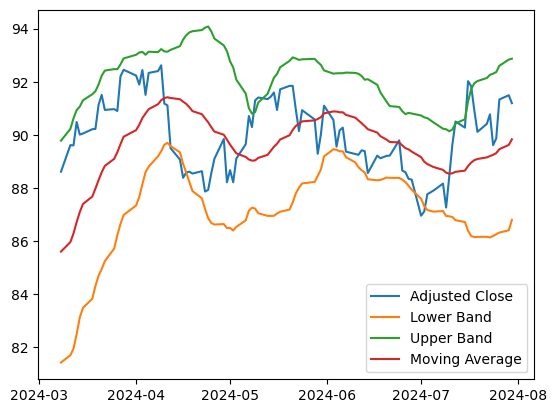

In [40]:
boll_data = data.dropna().iloc[-100:-1]
plt.plot(boll_data['Adj Close'],label='Adjusted Close')
plt.plot(boll_data['lower_band'],label='Lower Band')
plt.plot(boll_data['upper_band'],label='Upper Band')
plt.plot(boll_data['middle_band'],label='Moving Average')
plt.legend()

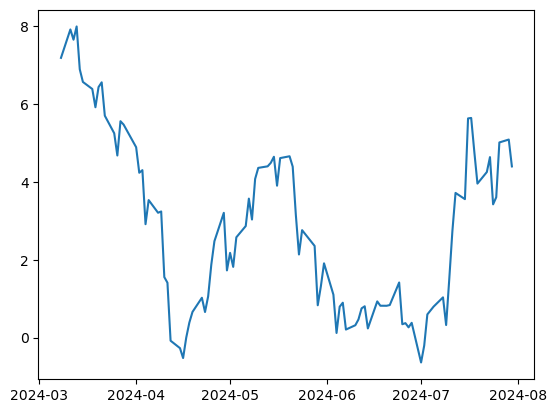

In [37]:
plt.plot(boll_data['Adj Close'] - boll_data['lower_band'])

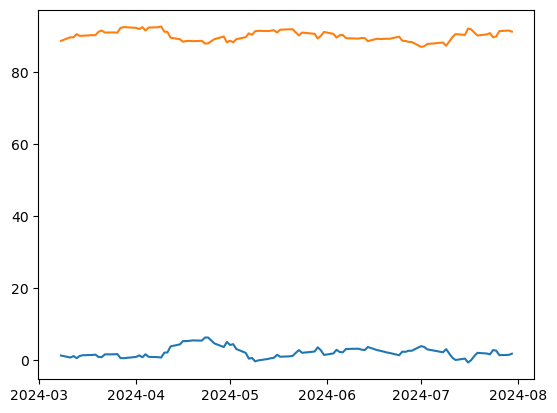

In [39]:
plt.plot(boll_data['upper_band']-boll_data['Adj Close'])
plt.plot(boll_data['Adj Close'])